# Universal Differential Equation for a 2D PDE heat equation

In this notebook we focus on the optimization of the global diffusivity parameter of the 2D heat equation without boundary conditions, 
$$
\frac{\partial T}{\partial t} = D \left( \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} \right), \qquad T(x,y,0) = g(x,y)
$$
where $T(x,y,t)$ the temperature field, and $D$ an unknown global constant. 

In [1]:
using Pkg; Pkg.activate("../../."); Pkg.instantiate()
using Plots; gr()
using Statistics
using LinearAlgebra
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using Tullio

  Activating environment at `~/Dropbox/Glacier UDE/ODINN_toy/Project.toml`


### Parameter declaration

In [2]:
nx, ny = 100, 100          # size of the grid
Δx, Δy = 1, 1              # lenght of each element in the grid (meters)
Δt = 0.02                   # temporal stepsize in the numerical method
t₁ = 1                    # final time in simulation
 
D₀ = 1                     # real diffusivity parameters
tolnl = 0                  # tolerance of the numerical method
itMax₀ = 100                 # maximum number of iterations of numerical method
damp = 0.85                # damping factor of numerical method
dτsc   = 1.0/3.0           # step in implicit numerical method
ϵ     = 1e-4               # small number
cfl  = max(Δx^2,Δy^2)/4.1; # stability parameter

We first define the functions that rule the evolution of the temperature field. We use a semi-implicit method (more ref)

In [3]:
function heatflow(T, D::Real, p, tol=tolnl, itMax=itMax₀) ## add tolerance here
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        #println("total iterations: ", iter)
        
        t += Δt
        
    end
    
    return T
    
end

heatflow (generic function with 3 methods)

In [4]:
dτ(x) = dτsc * min( 10.0 , 1.0/(1.0/Δt + (ϵ + x)/cfl))

function Heat(T, D, p)
   
    Δx, Δy, Δt, t₁ = p

    dTdx_edges = diff(T[:,2:end - 1], dims=1) / Δx
    dTdy_edges = diff(T[2:end - 1,:], dims=2) / Δy
    
    Fx = -D * dTdx_edges
    Fy = -D * dTdy_edges    
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) 

    dτ_ = dτ(2D₀)

    return F, dτ_
 
end

Heat (generic function with 1 method)

## Generate reference dataset

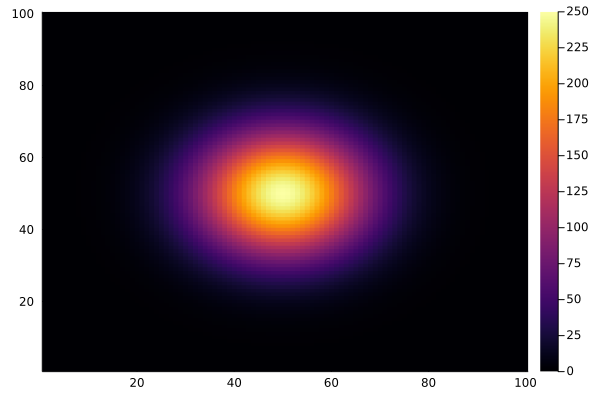

In [5]:
p = (Δx, Δy, Δt, t₁)

# initial condition
T₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]

# simulated evolution
T₁ = copy(T₀)
T₁ = heatflow(T₁, D₀, p, 1e-8, 300)

heatmap(T₀, clim=(0, maximum(T₀)))

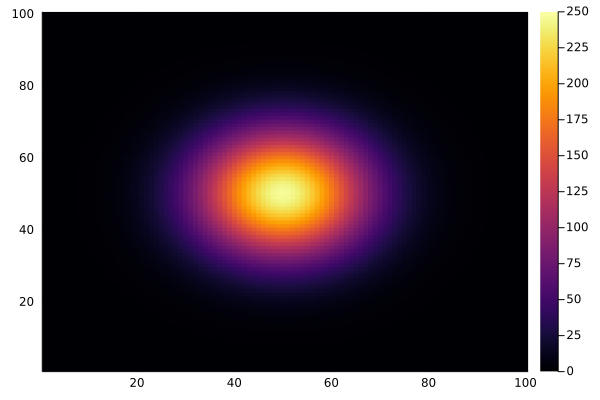

In [6]:
heatmap(T₁, clim=(0, maximum(T₀)))

In [7]:
maximum(T₁.-T₀)

0.4446140914308927

In [8]:
sqrt( sum((T₁.-T₀).^2) / (nx * ny) )

0.5058758826598624

## Automatic differentiation on the heat equation with respect to D

We perform automatic differentiation on the 2D PDE with respect to the diffusivity (D) in order to optimize it.

In [9]:
function loss(T, θ, p)
    uD = θ[1] 
    T = heatflow(T, uD, p)
    l_H = sqrt(Flux.Losses.mse(T, T₁; agg=mean))
    return l_H
end

loss (generic function with 1 method)

We can easily evaluate the loss function and its gradient with respect to $D$ using `Zygote`

In [10]:
T = copy(T₀)

loss_uD, back_uD = Zygote.pullback(D -> loss(T, [D], p), D\_0)

(Inf, Zygote.var"#46#47"{typeof(∂(#20))}(∂(#20)))

We test different D values in order to observe how the loss and the backpropagated gradients change.

In [11]:
all_D = LinRange(D₀/2, 3D₀/2, 50)
all_loss = zeros(0)
all_grad = zeros(0)

for d in all_D
    
    T = T₀
    loss_uD, back_uD = Zygote.pullback(D -> loss(T, D, p), d)
    
    println("difusivity: ", d)
    println("loss: ", loss_uD)
    #println("gradient: ", back_uD(1), "\n")
    
    append!(all_loss, loss_uD)
    append!(all_grad, back_uD(1)[1])
end

difusivity: 0.5
loss: 0.2517239098881476
difusivity: 0.5204081632653061
loss: 0.24140486866029515
difusivity: 0.5408163265306122
loss: 0.23109007759295042
difusivity: 0.5612244897959184
loss: 0.22077953387152552
difusivity: 0.5816326530612245
loss: 0.210473234684155
difusivity: 0.6020408163265306
loss: 0.2001711772216644
difusivity: 0.6224489795918366
loss: 0.1898733586775656
difusivity: 0.6428571428571429
loss: 0.1795797762480821
difusivity: 0.6632653061224489
loss: 0.1692904271321112
difusivity: 0.6836734693877551
loss: 0.15900530853122039
difusivity: 0.7040816326530612
loss: 0.14872441764966182
difusivity: 0.7244897959183674
loss: 0.1384477516943299
difusivity: 0.7448979591836734
loss: 0.12817530787481662
difusivity: 0.7653061224489796
loss: 0.11790708340332874
difusivity: 0.7857142857142857
loss: 0.10764307549474227
difusivity: 0.8061224489795918
loss: 0.09738328136657291
difusivity: 0.826530612244898
loss: 0.08712769823898334
difusivity: 0.8469387755102041
loss: 0.0768763233347673

LoadError: InterruptException:

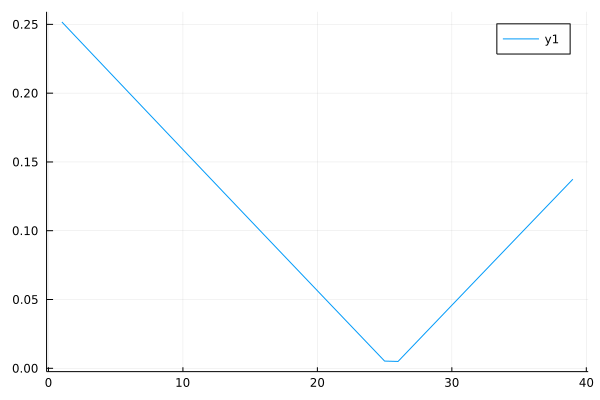

In [15]:
plot(all_loss)

In [12]:
plot(all_D, all_loss)
vline!([D₀])

BoundsError: BoundsError: attempt to access 39-element Vector{Float64} at index [1:50]

In [13]:
plot(all_D, all_grad)
hline!([0])

BoundsError: BoundsError: attempt to access 39-element Vector{Float64} at index [1:50]

## AD with respect to D in order to optimize it

We now use Zygote in order to perform AD on the 2D heat equation and we optimize D using an ADAM gradient descent. 

In [29]:
function train(loss, p)
    
    θ = [D₀/3]
    opt = ADAM(0.05)
    @epochs 20 hybrid_train!(loss, θ, p, opt)
    
    return θ
    
end

function hybrid_train!(loss, θ, p, opt)
        
    T = T₀
    loss_uD, back_uD = Zygote.pullback(θ -> loss(T, θ, p), θ)
    
    ∇_uD = back_uD(one(loss_uD))[1]
    
    println("Loss: ", loss_uD)
    println("Current parameter: ", θ)
    println("Gradient: ", ∇_uD)
    println("opt: ", opt)
    
    Flux.Optimise.update!(opt, θ, ∇_uD)
    
end

hybrid_train! (generic function with 1 method)

In [ ]:
#θ₁ = train(loss, p)  #  I STILL GET AN ERROR HERE
#D = θ₁[1]

Finally, this is the value for $D$ that we find after performing optimization with respect of the numerical methods:

In [ ]:
D

### What happen when the solver depends on the parameters?

In [9]:
function Heat_adaptive(T, D, p)
   
    Δx, Δy, Δt, t₁ = p

    dTdx_edges = diff(T[:,2:end - 1], dims=1) / Δx
    dTdy_edges = diff(T[2:end - 1,:], dims=2) / Δy
    
    Fx = -D * dTdx_edges
    Fy = -D * dTdy_edges    
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) 

    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D))))
    #dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + (ϵ + D)/cfl))
    
    return F, dτ
 
end

function heatflow_adaptive(T, D::Real, p, tol=1e-4, itMax=50)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            F, dτ = Heat_adaptive(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        #println("total iterations: ", iter)
        
        t += Δt
        
    end
    
    return T
    
end

function loss_adaptive(T, θ, p)
    uD = θ[1] 
    T = heatflow_adaptive(T, uD, p)
    l_H = sqrt(Flux.Losses.mse(T, T₁; agg=mean))
    return l_H
end

loss_adaptive (generic function with 1 method)

In [10]:
all_D_adaptive = LinRange(D₀/2, 3D₀/2, 50)
all_loss_adaptive = zeros(0)
all_grad_adaptive = zeros(0)

for d in all_D_adaptive
    
    T = T₀
    loss_uD, back_uD = Zygote.pullback(D -> loss_adaptive(T, D, p), d)
    
    println("difusivity: ", d)
    println("loss: ", loss_uD)
    println("gradient: ", back_uD(1), "\n")
    
    append!(all_loss_adaptive, loss_uD)
    append!(all_grad_adaptive, back_uD(1)[1])
     
end

difusivity: 0.5
loss: 0.18352383814947135
gradient: (-0.6405922247346477,)

difusivity: 0.5204081632653061
loss: 0.17033011742462278
gradient: (-0.6404941210872062,)

difusivity: 0.5408163265306122
loss: 0.1571390304508785
gradient: (-0.6403860618835366,)

difusivity: 0.5612244897959184
loss: 0.1439511567554802
gradient: (-0.6402681331285667,)

difusivity: 0.5816326530612245
loss: 0.1307670698737707
gradient: (-0.6401404208125089,)

difusivity: 0.6020408163265306
loss: 0.11758733734183317
gradient: (-0.6400030108860232,)

difusivity: 0.6224489795918366
loss: 0.10441252069092452
gradient: (-0.6398559892258323,)

difusivity: 0.6428571428571429
loss: 0.0912431754441772
gradient: (-0.6396994415784035,)

difusivity: 0.6632653061224489
loss: 0.07807985111638417
gradient: (-0.6395334534483182,)

difusivity: 0.6836734693877551
loss: 0.12209520529300223
gradient: (-0.5570556940926943,)

difusivity: 0.7040816326530612
loss: 0.11056067279028535
gradient: (-0.5570385761727663,)

difusivity: 0.7244

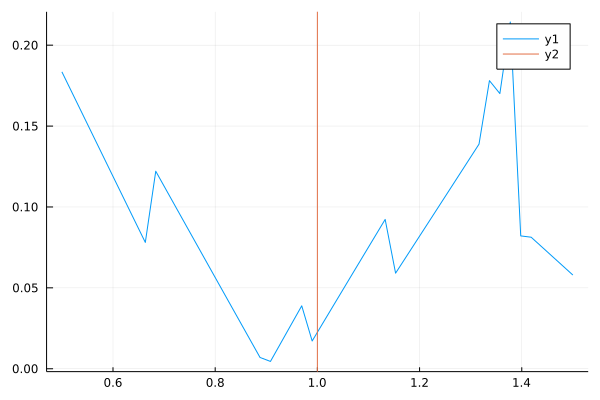

In [11]:
plot(all_D_adaptive, all_loss_adaptive)
vline!([D₀])

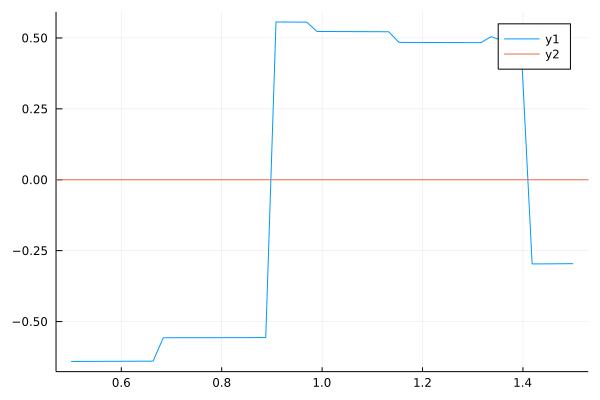

In [12]:
plot(all_D_adaptive, all_grad_adaptive)
hline!([0])